In [1]:
!pip install matplotlib==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install hazm
!pip install stopwords_guilannlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 4.3 MB/s 
     |████████████████████████████████| 233 kB 45.5 MB/s 
     |████████████████████████████████| 1.4 MB 49.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=20d6785266f1dc86c2dea88dfc1f02d6a51a10739fc13d06210ae44f9265c6af
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=154968 sha256=b9eec3f32e625433a730e9337dbc5a9164bf2c30338af41df274e2dfbe440f55
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://p

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get FastText

In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

--2023-01-01 15:28:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105157170 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.fa.vec’

wiki.fa.vec         100%[===================>]   1.03G  16.1MB/s    in 58s     

2023-01-01 15:29:57 (18.1 MB/s) - ‘wiki.fa.vec’ saved [1105157170/1105157170]



In [5]:
import numpy as np
import pandas as pd
import codecs
from google.colab import files
import re
from gensim.models import KeyedVectors
import gensim

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from stopwords_guilannlp import stopwords_output
from hazm import *

import matplotlib.pyplot as plt
from keras.utils import plot_model

from sklearn.metrics import f1_score

In [6]:
uploaded = files.upload()

Saving Karaj.csv to Karaj.csv



# Making Datasets

In [7]:
data = pd.read_csv('Karaj.csv', index_col=None, header=None, encoding="utf-8")

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
1,1573462153394257931,1573462153394257931,2022-09-23 23:59:45 UTC,2022-09-23,23:59:45,+0000,1186219745118429184,chighahve,Ghahve_chi,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1573461960187944961,1573461960187944961,2022-09-23 23:58:59 UTC,2022-09-23,23:58:59,+0000,1280585661385449473,mhdiesmaeili,واشر ته‌سیلندر,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1573461356916899865,1573461356916899865,2022-09-23 23:56:35 UTC,2022-09-23,23:56:35,+0000,1089983875110105091,n92077,n,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1573461125047410688,1573461125047410688,2022-09-23 23:55:40 UTC,2022-09-23,23:55:40,+0000,1186219745118429184,chighahve,Ghahve_chi,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [12]:
tweets = data.drop_duplicates(subset=[0]).drop(data.index[0])

In [144]:
texts = tweets[10]
dates = tweets[3]
times = tweets[4]

# Preprocess

In [14]:
normalizer = Normalizer()

def normalize_it(doc):
    temp = re.sub(r'\d+', '', doc)
    temp = re.sub(r"(?:\@|https?\://)\S+", "", temp)
    temp = re.sub(r'\s*[A-Za-z]+\b', '' , temp).replace("#", "").replace("_", " ")
    temp = URLless_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(temp))
    temp = normalizer.normalize(temp)
    temp = normalizer.character_refinement(temp)
    temp = normalizer.punctuation_spacing(temp)
    temp = normalizer.affix_spacing(temp)
    #temp = re.sub('[\W_]+', '', temp)
    return temp

In [15]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

def clean_doc(doc):
    doc = normalize_it(doc)
    tokenized = word_tokenize(doc)
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    #tokens = normalizer.token_spacing(tokens)
    #tokens = [w for w in tokens if not w in stop_set]  #remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens = ' '.join(tokens)
    return tokens

In [19]:
cleaned = np.empty_like(texts)
for index, document in enumerate(texts):
  cleaned[index] = clean_doc(str(document))

# Prepare FastText Model

In [17]:
EMBEDDING_FILE = 'wiki.fa.vec'
#EMBEDDING_FILE = '/content/drive/MyDrive/SocioSent/wiki.fa.vec'

# FastText embedding dimensionality
embed_size = 300

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []
  for ft_word in ft_model.vocab:
      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

In [ ]:
# Load:
ft_words = pd.read_csv('ft_words.csv').values.tolist()
ft_moldel2 = gensim.models.KeyedVectors.load_word2vec_format('ft_model.bin', binary=True)

In [21]:
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

test_docs = cleaned

## Setting tokenizer up:

In [26]:
num_words = 2000

tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(test_docs)

max_length = max([len(s.split()) for s in test_docs])

## Embed sentences

In [30]:
encoded_docs = tokenizer.texts_to_sequences(test_docs)

x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index)

nb_words = len(tokenizer.word_index)

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
   
    if word in ft_model.vocab:
        embedding_vector = ft_model[word]

        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

total embedded: 1768 common words
Embedding matrix shape: (1768, 300)


# Predicting the labels:

## B-LSTM Model

In [32]:
# load the Model:
from keras.models import load_model

model_blstm = load_model('/content/drive/MyDrive/SocioSent/BLSTM_model.h5')

In [ ]:
# Get prediction label
preds = model_blstm.predict(x_test_padded)
y_pred_blstm = np.argmax(preds, axis=1)

## CNN Model

In [36]:
# load the Model:
from keras.models import load_model

model_cnn = load_model('/content/drive/MyDrive/SocioSent/CNN_model.h5')

In [37]:
# Get prediction labels
preds = model_cnn.predict(x_test_padded)
y_pred_cnn = np.argmax(preds, axis=1)

13/13 [==============================] - 1s 17ms/step


In [38]:
preds = y_pred_cnn

# Statistical Analysis:

**primary plots:**

In [42]:
from collections import Counter
cnt = Counter(preds)
cnt = dict(cnt)
print(cnt)

{0: 123, 2: 122, 1: 148}


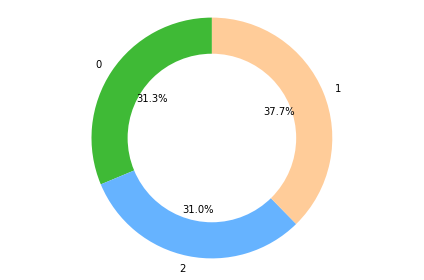

In [43]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()

# plt.savefig('distribution.png')
plt.show()

Creat Sentimental time series:

In [180]:
dates = tweets[3].dropna()
dates_spec = dates[~dates.duplicated()].tolist()
indexes = []
counts = []
tweets_per_day = dates.value_counts().tolist()

for d in dates_spec:
  indexes.append(dates.loc[dates == d].index.tolist())

#x = preds_df.iloc[indexes[0]]

for idxs in indexes:
  vals = []
  for i in idxs:
    vals.append(preds[i-1])
  counts.append(pd.DataFrame(vals).value_counts())

In [181]:
print(counts)

[0    108
2     93
1     66
dtype: int64, 2    29
0    15
1    15
dtype: int64]


In [182]:
date_num = len(counts)
seriesFor_i = [[],[],[]]

for count in counts:
  seriesFor_i[0].append(count[0])
  seriesFor_i[1].append(count[1])
  seriesFor_i[2].append(count[2])

series = pd.DataFrame({
    0: seriesFor_i[0],
    1: seriesFor_i[1],
    2: seriesFor_i[2]
})

normalized = series.div(series.sum(axis=1), axis=0)

In [183]:
print(series)
print(normalized)

     0   1   2
0  108  66  93
1   15  15  29
          0         1         2
0  0.404494  0.247191  0.348315
1  0.254237  0.254237  0.491525


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


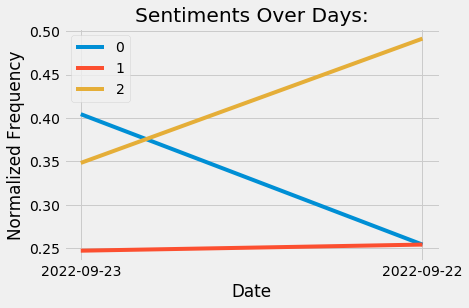

In [188]:
import matplotlib.pyplot as plt
 
t = dates_spec
plt.style.use("fivethirtyeight")

plt.figure()

plt.xlabel("Date")
plt.ylabel("Normalized Frequency")
plt.title("Sentiments Over Days:")
plt.plot(t, normalized[0], t, normalized[1], t, normalized[2])
plt.legend(['0','1','2'])

In [189]:
!pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16127 sha256=de5f22e9e635cd89452c0f53110cb38cbe27fce3a8e2cee642ee75f8eef14630
  Stored in directory: /root/.cache/pip/wheels/e8/78/c8/18d4f4804753e14416809b365773220c48b41fe5387f2bb6b9
Successfully built pytrends


In [191]:
import pandas as pd
from pytrends.request import TrendReq
Trending_topics = TrendReq(hl='fa', tz=360)

In [ ]:
import matplotlib.pyplot as plt

dt = 0.01

s1 = normalized[1]
s2 = search_rate

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, s1, t, s2)
axs[0].set_xlim(0, 2)
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Sentiment and Search')
axs[0].grid(True)

cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
axs[1].set_ylabel('Coherence')

fig.tight_layout()
plt.show()